# LIBRARIES

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm
import librosa
import librosa.display
import pylab
import cv2


In [ ]:
data_path =  '/content/drive/MyDrive/deep_fake_feature_extraction.csv'
data2_path = '/content/drive/MyDrive/deep_fake_feature_extraction2.csv'
data3_path = '/content/drive/MyDrive/deep_fake_feature_extraction3.csv'
from sklearn.impute import SimpleImputer



data = pd.read_csv(data_path)
data2 = pd.read_csv(data2_path)
data3 = pd.read_csv(data3_path)
data = pd.concat([data, data2, data3], axis = 0)
features_columns = list(data.columns)
# Imputation
my_imputer = SimpleImputer()
data = pd.DataFrame(my_imputer.fit_transform(data))
data.columns = features_columns
features = data.drop('label', axis = 1)
label = data['label']
data.label.value_counts

<bound method IndexOpsMixin.value_counts of 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
24779    1.0
24780    1.0
24781    1.0
24782    1.0
24783    1.0
Name: label, Length: 24784, dtype: float64>

# TEST SPLIT

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_valid,y_train,y_valid = train_test_split(features,label,test_size=0.3,random_state=0)
y_train.value_counts()

0.0    13524
1.0     3824
Name: label, dtype: int64

# OVER SAMPLING

In [ ]:

from sklearn.utils import resample
train_data = pd.concat([x_train, y_train], axis=1)
# separate minority and majority classes
negative = train_data[train_data.label==1.0]
positive = train_data[train_data.label==0.0]
# downsample majority
neg_downsampled = resample(negative,
 replace=True, # sample with replacement
 n_samples=len(positive), # match number in minority class
 random_state=27) # reproducible results
# combine minority and downsampled majority
downsampled = pd.concat([positive, neg_downsampled])
# check new class counts

x_train = downsampled.drop('label', axis = 1)
y_train = downsampled['label']
downsampled.label.value_counts()

0.0    13524
1.0    13524
Name: label, dtype: int64

# FEATURE SCALING

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train) # where X is your data to be scaled
x_train = pd.DataFrame(scaler.transform(x_train))
x_valid = pd.DataFrame(scaler.transform(x_valid))
x_train.columns = features.columns
x_valid.columns = features.columns
print(x_train.columns)


Index(['mfcc', 'mfcc.1', 'mfcc.2', 'mfcc.3', 'mfcc.4', 'mfcc.5', 'mfcc.6',
       'mfcc.7', 'mfcc.8', 'mfcc.9',
       ...
       'contrast.3', 'contrast.4', 'contrast.5', 'contrast.6', 'tonnetz',
       'tonnetz.1', 'tonnetz.2', 'tonnetz.3', 'tonnetz.4', 'tonnetz.5'],
      dtype='object', length=193)


# IMPUTER

In [ ]:
from sklearn.impute import SimpleImputer

# Imputation
my_imputer = SimpleImputer()
x_train = pd.DataFrame(my_imputer.fit_transform(x_train))
x_valid = pd.DataFrame(my_imputer.transform(x_valid))

x_train.columns = features.columns
x_valid.columns = features.columns




# CONFUSION MATRIX

In [ ]:
def create_confusion_matrix(cm_plot_labels, name, y_true,y_pred, map_col):
    #Get the true and predicted labels
    y_predict_classes, y_true_classes = y_pred,y_true

    #Compute the confusion matrix
    confusion_matrix_computed = confusion_matrix(y_true_classes, y_predict_classes)

    #Plot the confusion matrix
    plot_confusion_matrix(confusion_matrix_computed, cm_plot_labels, name, map_col) 
    # plot_confusion_matrix(conf_mat=confusion_matrix_computed, class_names=cm_plot_labels)
classes = ["Fake", "Real"]
name = "Confusion matrix"
def plot_confusion_matrix(cm, classes,
                          name,
                          cmap,
                          normalize=False,
                          title='Confusion matrix'):
    
    plt.figure(figsize=(6,4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(name)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, weight = 'bold')
    plt.yticks(tick_marks, classes, weight = 'bold')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
#     b, t = plt.ylim()
#     b += 0.5
#     t -= 0.5
#     plt.ylim(b, t)
    
    plt.tight_layout()
    plt.ylabel('True Labels', fontweight='bold')
    plt.xlabel('Predicted Labels', fontweight='bold')
    fig = plt
    # fig.savefig('/content/drive/MyDrive/skin-cancer-mnist-ham10000' + name + '_confusion_matrix.png', dpi=300)

# SVM

In [ ]:
from sklearn.svm import SVC
model = SVC(C=0.1, gamma=1, kernel='poly')

In [ ]:
model.fit(x_train, y_train)

SVC(C=0.1, gamma=1, kernel='poly')

In [ ]:
y_pred = model.predict(x_valid)


In [ ]:
from sklearn.metrics import accuracy_score

# printing the accuracy of the model
print(accuracy_score(y_valid, y_pred))

0.9458041958041958


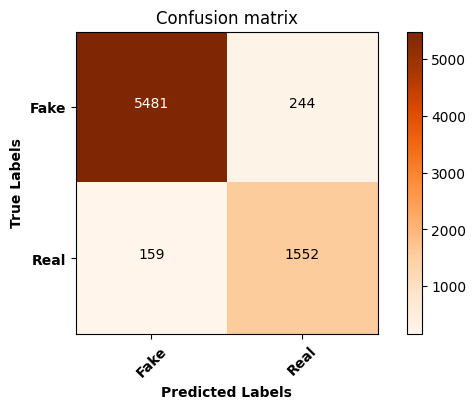

In [ ]:
# importing the required modules
import seaborn as sns
from sklearn.metrics import confusion_matrix

classes = ["Fake", "Real"]
name = "Confusion matrix"
# passing actual and predicted values`
create_confusion_matrix(classes, name = name, y_true = y_valid[:len(y_pred)], y_pred = y_pred, map_col = 'Oranges')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_valid,y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96      5725
         1.0       0.86      0.91      0.89      1711

    accuracy                           0.95      7436
   macro avg       0.92      0.93      0.92      7436
weighted avg       0.95      0.95      0.95      7436



In [ ]:
model.score(x_valid, y_valid)

0.9497041420118343

# KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(x_train, y_train)
knn.score(x_valid, y_valid)

0.9458041958041958

In [ ]:
y_pred = knn.predict(x_valid)
from sklearn.metrics import classification_report
print(classification_report(y_valid,y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96      5725
         1.0       0.86      0.91      0.89      1711

    accuracy                           0.95      7436
   macro avg       0.92      0.93      0.93      7436
weighted avg       0.95      0.95      0.95      7436



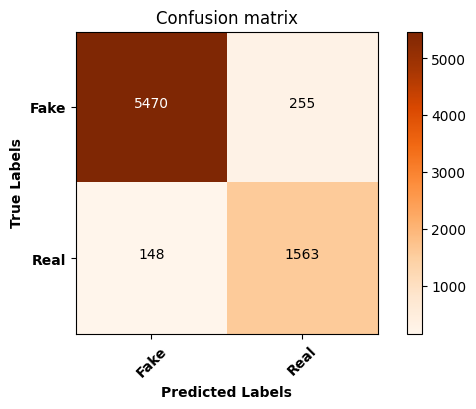

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = knn.predict(x_valid)

# passing actual and predicted values
create_confusion_matrix(classes, name = name, y_true = y_valid[:len(y_pred)], y_pred = y_pred, map_col = 'Oranges')



# XG BOOST

              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96      5725
         1.0       0.86      0.86      0.86      1711

    accuracy                           0.94      7436
   macro avg       0.91      0.91      0.91      7436
weighted avg       0.94      0.94      0.94      7436

0.935449166218397


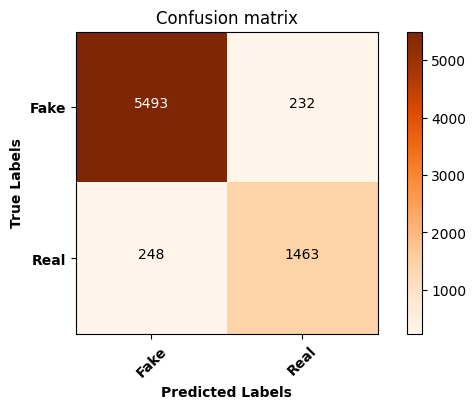

In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

data_dmatrix = xgb.DMatrix(data=x_train, label=y_train)
data_dmatrix

params = {
    'objective':'binary:logistic',
    'max_depth':4,
    'alpha':10,
    'learning_rate':1.0,
    'n_estimators':100
}

model = XGBClassifier(**params)

model.fit(x_train,y_train)

y_pred = model.predict(x_valid)

print(classification_report(y_valid,y_pred))

from sklearn.metrics import accuracy_score
print(accuracy_score(y_valid,y_pred))
create_confusion_matrix(classes, name = name, y_true = y_valid[:len(y_pred)], y_pred = y_pred, map_col = 'Oranges')

# MLP

0.9607315761161915


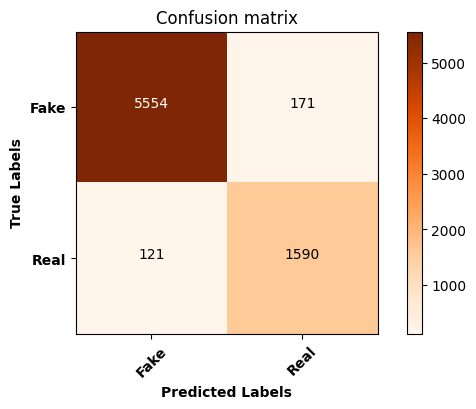

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
X, y = make_classification(n_samples=100, random_state=1)
# X_train, X_test, y_train, y_test = train_test_split(features, label)
model = MLPClassifier(random_state=1, max_iter=300).fit(x_train, y_train)
y_pred = model.predict(x_valid)
print(model.score(x_valid, y_valid))

create_confusion_matrix(classes, name = name, y_true = y_valid[:len(y_pred)], y_pred = y_pred, map_col = 'Oranges')


# GRADIENT BOOSTING

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
# X_train,X_test,y_train,y_test=train_test_split(features,label,test_size=0.3,random_state=101)

from sklearn.ensemble import GradientBoostingClassifier
param={'n_estimators':(5,10,20,40,60,80,100,120,140,160,180),'learning_rate':(0.1,0.2,0.4,0.8,1.0,1.2,1.6)}

model  = GradientBoostingClassifier()
model.fit(x_train,y_train)
model.score(x_valid,y_valid)

0.884480903711673

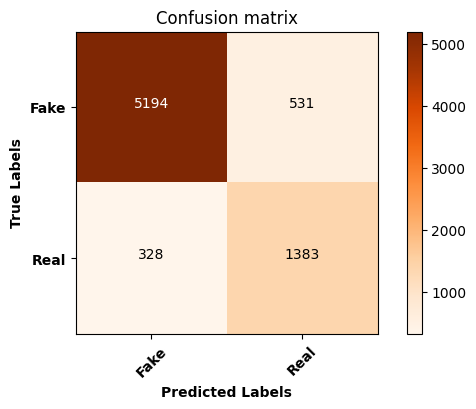

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = model.predict(x_valid)

# passing actual and predicted values
create_confusion_matrix(classes, name = name, y_true = y_valid[:len(y_pred)], y_pred = y_pred, map_col = 'Oranges')




# RANDOM FOREST

0.9353146853146853


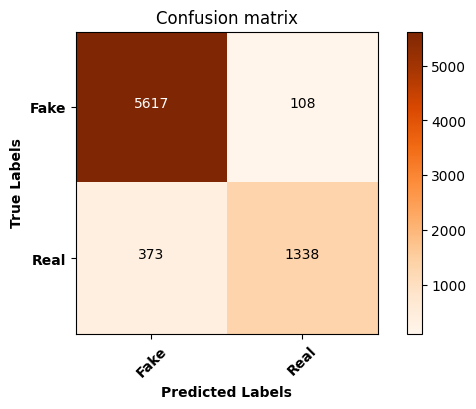

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=201,criterion = "entropy")
model.fit(x_train, y_train)
model.score(x_valid,y_valid)
y_pred = model.predict(x_valid)
from sklearn.metrics import accuracy_score

# printing the accuracy of the model
print(accuracy_score(y_valid, y_pred))
y_pred = model.predict(x_valid)
from sklearn.metrics import accuracy_score
create_confusion_matrix(classes, name = name, y_true = y_valid[:len(y_pred)], y_pred = y_pred, map_col = 'Oranges')

# PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(0.90)
features_pca = pca.fit_transform(features)

In [ ]:
X_train_pca, X_test_pca, y_train, y_test = train_test_split(features_pca, label, test_size=0.3, random_state=30)

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train_pca, y_train)
model.score(X_test_pca, y_test)

0.8114577729962346

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train_pca, y_train)
knn.score(X_test_pca, y_test)

0.8570467993544917

In [ ]:
from sklearn.svm import SVC
model = SVC()
model.fit(X_train_pca, y_train)
model.score(X_test_pca, y_test)

0.8485745024206562

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=25)
model.fit(X_train_pca, y_train)
model.score(X_test_pca,y_test)

0.9190424959655729

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = knn.predict(X_test_pca)



In [ ]:
from sklearn import svm, feature_selection
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import numpy as np
import joblib



# Shuffle dataset
X = features
y = label
X, y = shuffle(X, y, random_state=42)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define SVM model
svm_model = svm.SVC(kernel='linear', probability=True)

# Define feature selection and PCA pipelines
feature_selection_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('feature_selection', feature_selection.SelectKBest(feature_selection.f_classif, k=1000)),
    ('pca', PCA(n_components=200))
])

# Define SVM pipeline with feature selection and PCA
svm_pipeline = Pipeline([
    ('feature_selection_pca', feature_selection_pipeline),
    ('svm', svm_model)
])

# Define hyperparameters for grid search
params = {
    'feature_selection_pca__feature_selection__k': [100, 500, 1000],
    'feature_selection_pca__pca__n_components': [50, 100, 200],
    'svm__C': [0.1, 1, 10],
    'svm__gamma': [0.1, 1, 10]
}

# Perform grid search to find optimal hyperparameters
svm_grid_search = GridSearchCV(svm_pipeline, params, cv=5, n_jobs=-1)
svm_grid_search.fit(X_train, y_train)

# Print best hyperparameters
print("Best parameters: ", svm_grid_search.best_params_)

# Evaluate model on test set
y_pred = svm_grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

